In [1]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import Dataset, load_dataset
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler
from tqdm import tqdm
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import random
import pandas as pd
from collections import Counter
import pickle
import joblib
from copy import deepcopy


sns.set_style('whitegrid')

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

violet = '#702b9d'
RANDOM_SEED = 1002

checkpoint = 'FacebookAI/xlm-roberta-base'
batch_size = 12 


In [2]:
from transformers import XLMRobertaModel
from main_soft_align_swap import *

base_model = XLMRobertaModel.from_pretrained( checkpoint)
tokenizer = AutoTokenizer.from_pretrained( checkpoint)
Eval = namedtuple('Eval', ['predictions', 'label_ids'])
src = 'es'
tgt = 'de'

en_train = Dataset.from_file(os.getcwd() + f'/data_{src}/{src}.train/data-00000-of-00001.arrow')
zh_train = Dataset.from_file(os.getcwd() + f'/data_{tgt}/{tgt}.train/data-00000-of-00001.arrow')
    
zh_val = Dataset.from_file(os.getcwd() + f'/data_{tgt}/{tgt}.dev/data-00000-of-00001.arrow')
para_dataset = deepcopy(en_train)
para_dataset = para_dataset.add_column("target_utt", zh_train['utt'])
para_dataset = para_dataset.add_column("target_slots", zh_train['slots_str'])
para_dataset = para_dataset.add_column("target_intents", zh_train['intent_str'])
para_dataset = para_dataset.map(lambda x: convert_train(x, src = 'es'), batched=True)    

para_dataloader = DataLoader(para_dataset, batch_size= batch_size, shuffle=True, 
                            collate_fn=CollatorMASSIVEIntentClassSlotFill_para(tokenizer=tokenizer, max_length=512))
train_dataloader = DataLoader(en_train, batch_size= batch_size, shuffle=False, 
                            collate_fn=CollatorMASSIVEIntentClassSlotFill(tokenizer=tokenizer, max_length=512))
eval_dataloader = DataLoader(zh_val, batch_size= batch_size, shuffle=False,
                                collate_fn=CollatorMASSIVEIntentClassSlotFill(tokenizer=tokenizer, max_length=512))
train_eval_dataloader = DataLoader(zh_train, batch_size= batch_size, shuffle=True,
                                collate_fn=CollatorMASSIVEIntentClassSlotFill(tokenizer=tokenizer, max_length=512))
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)

 # load mappings: should be using en mapping since order matters
with open(os.getcwd() + f'/data_{src}/{src}.intents', 'r', encoding = 'UTF-8') as file:
    intent_labels_map = json.load(file)

with open(os.getcwd() + f'/data_{src}/{src}.slots', 'r', encoding = 'UTF-8') as file:
    slot_labels_map = json.load(file)

with open(os.getcwd() + f'/data_{tgt}/{tgt}.intents', 'r', encoding = 'UTF-8') as file:
    zh_intent_labels_map = json.load(file)

with open(os.getcwd() + f'/data_{tgt}/{tgt}.slots', 'r', encoding = 'UTF-8') as file:
    zh_slot_labels_map =json.load(file)
    

base_model = XLMRobertaModel.from_pretrained('FacebookAI/xlm-roberta-base')
model = MultiTaskICSL(base_model, vocab_size, num_slot_labels=56, num_intents=60)


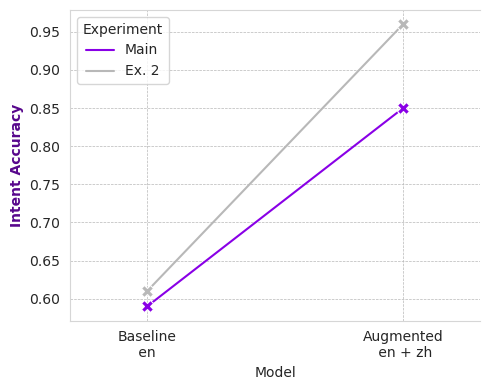

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd 

# Example data
metrics = ['Baseline\n en ', 'Augmented\n en + zh']

fig, ax = plt.subplots(figsize=(5, 4))

# Define x positions for the line plot
x_positions = np.arange(len(metrics))

# data = pd.DataFrame({
#     'Model': ['Baseline', 'Combined'],
#     'Intent Accuracy': [0.55, 0.85]
# })

data = pd.DataFrame({
    'Model': ['Baseline', 'Baseline', 'Augmented', 'Augmented'],
    'Intent Accuracy': [0.44, 0.43, 0.52, 0.54],
    'Experiment': ['Main','Ex. 2','Main','Ex. 2']
})

# Set the aesthetic style of the plots

sns.lineplot(x='Model', y='Intent Accuracy', data=data, hue = 'Experiment', 
             marker= 'X', palette = ['#8900e6', '#b8b8b8'], lw = 1.5, markersize = 8, ax = ax)
# Setting the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(metrics)

# Adjusting the x-axis limits to make the labels closer
ax.set_xlim(-0.3, 1.3)  # Narrowing the x-axis limits
# Styling
ax.set_ylabel('Slot F1', color='#57068C', fontweight='bold')
# ax.set_ylim(0.3,0.6)
ax.grid(True, linestyle='--', linewidth=0.5, color='#b8b8b8')

# Spine colors
ax.spines['left'].set_color('#d6d6d6')
ax.spines['bottom'].set_color('#d6d6d6')
ax.spines['top'].set_color('#d6d6d6')
ax.spines['right'].set_visible(False)

# Title and layout adjustments
# plt.title('Intent Accuracy: Baseline vs Combined')
plt.tight_layout()

plt.show()

fig.savefig('f1.png', bbox_inches = 'tight', dpi = 500)